# 项目背景

为提高店铺的收益，进行准确的客户运营策略，使用kaggle提供的某化妆品电商2019年10月至2020年02月的销售数据进行分析，根据网站流量数据、客户转化率数据、客户消费趋势、消费习惯把握客户的消费现状和心理，并进行新老顾客划分以及基于RFM模型的客户分群，挖掘出高价值用户群体，完善销售运营策略。

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# 一、 数据探查

In [2]:
#查看数据文件，读取数据集
print(os.listdir('./data/'))
df = pd.DataFrame()
for file in os.listdir('./data'):
    df = pd.concat([df,pd.read_csv(os.path.join('./data',file))])
df = df.reset_index(drop=True)

['2019-Dec.csv', '2019-Nov.csv', '2019-Oct.csv', '2020-Feb.csv', '2020-Jan.csv']


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB


## 1.1数据缺失情况探查

In [4]:
df.isnull().any()

event_time       False
event_type       False
product_id       False
category_id      False
category_code     True
brand             True
price            False
user_id          False
user_session      True
dtype: bool

category_code和brand以及user_session有缺失

In [5]:
missing_info = pd.DataFrame(columns=['Miss_Value_Counts','Miss_Value_Precent'])
missing_info['Miss_Value_Counts'] = [sum(df.category_code.isnull()),sum(df.brand.isnull()),sum(df.user_session.isnull())]
missing_info['Miss_Value_Precent'] = missing_info['Miss_Value_Counts']/df.shape[0]
missing_info.index = ['category_code','brand','user_session']
missing_info

,Miss_Value_Counts,Miss_Value_Precent
category_code,20339246,0.982912
brand,8757117,0.423196
user_session,4598,0.000222


产品类别代码category_code和产品品牌brand列缺失严重，影响使用。

## 1.2 数据异常值检查

In [6]:
df.describe()

,product_id,category_id,price,user_id
count,2.069284e+07,2.069284e+07,2.069284e+07,2.069284e+07
mean,5.484297e+06,1.554230e+18,8.534735e+00,5.215527e+08
std,1.305716e+06,1.691038e+17,1.938142e+01,8.744312e+07
min,3.752000e+03,1.487580e+18,-7.937000e+01,4.654960e+05
25%,5.724650e+06,1.487580e+18,2.060000e+00,4.818306e+08
50%,5.810720e+06,1.487580e+18,4.050000e+00,5.531297e+08
75%,5.857864e+06,1.487580e+18,7.060000e+00,5.788573e+08
max,5.932595e+06,2.242903e+18,3.277800e+02,6.220902e+08


可以看出，价格列的最小值为负数，为异常值，需要进行修正。

# 1.3 数据预处理

In [7]:
df.price = df.price.apply(lambda x: 0 if x<0 else x)

In [8]:
#处理时间，去掉UTC
def get_datetime(data):
    datetime= ' '.join((data.split(' ')[0],data.split(' ')[1]))
    return datetime
df.event_time=df.event_time.map(get_datetime)

In [9]:
#由于后续需要进行按月分组和时间段的操作，这里进行提取月份、日期、时间、小时
df['year_month']=df.event_time.apply(lambda x:'-'.join((x.split('-')[0],x.split('-')[1])))
df['time']=df.event_time.apply(lambda x:x.split(' ')[1])
df['date']=df.event_time.apply(lambda x:x.split(' ')[0])
df['hour']=df.event_time.apply(lambda x:(x.split(' ')[1]).split(':')[0])

In [10]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year_month,time,date,hour
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019-12,00:00:00,2019-12-01,00
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019-12,00:00:00,2019-12-01,00
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019-12,00:00:02,2019-12-01,00
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019-12,00:00:05,2019-12-01,00
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019-12,00:00:07,2019-12-01,00


# 二、电商网站页面浏览量分析

## 2.1 页面浏览量指标

In [11]:
#求出总页面浏览量、日均页面浏览量、日最大页面浏览量和日最小页面浏览量
pv_all = df.shape[0]
pv_daily = df.date.value_counts()
pv_mean = np.mean(pv_daily)
pv_max = max(pv_daily)
pv_min = min(pv_daily)

print('{:*^30}'.format('201910至202002期间页面浏览量指标'))
print('总页面浏览量:',pv_all)
print('日均页面浏览量:',pv_mean)
print('日最大页面浏览量:{},日期为:{}'.format(pv_max,pv_daily[pv_daily==max(pv_daily)].index[0]))
print('日最小页面浏览量:{},日期为:{}'.format(pv_min,pv_daily[pv_daily==min(pv_daily)].index[0]))

****201910至202002期间页面浏览量指标****
总页面浏览量: 20692840
日均页面浏览量: 136137.1052631579
日最大页面浏览量:270074,日期为:2019-11-22
日最小页面浏览量:31096,日期为:2019-12-31


## 2.2 日/月浏览量趋势 

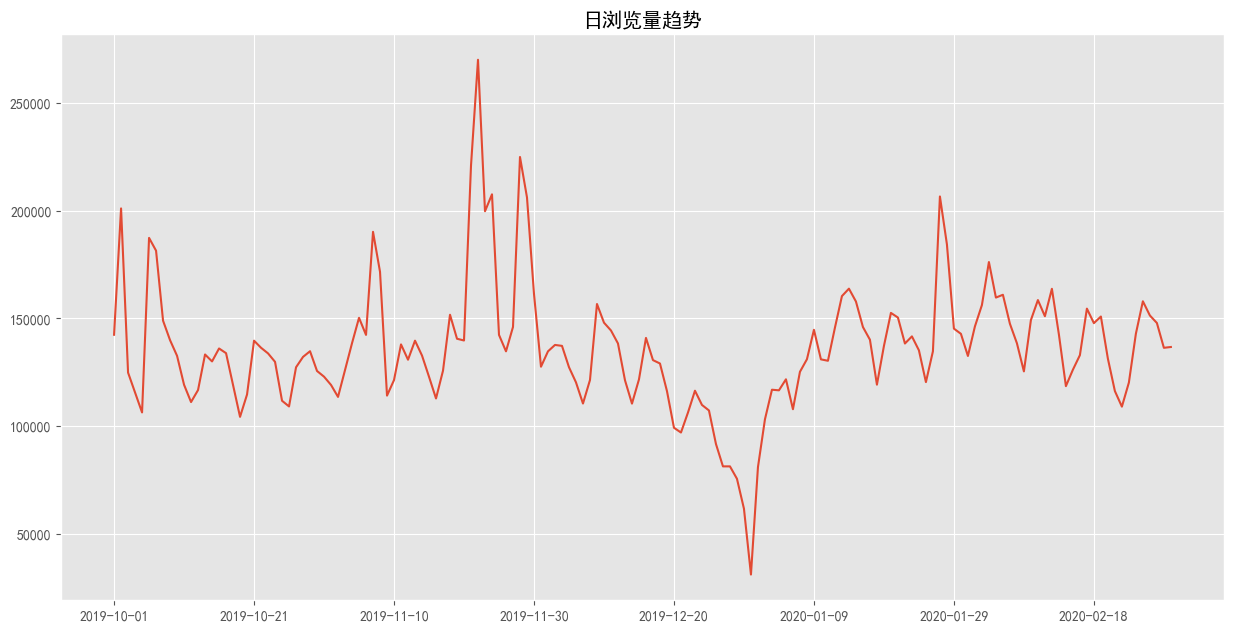

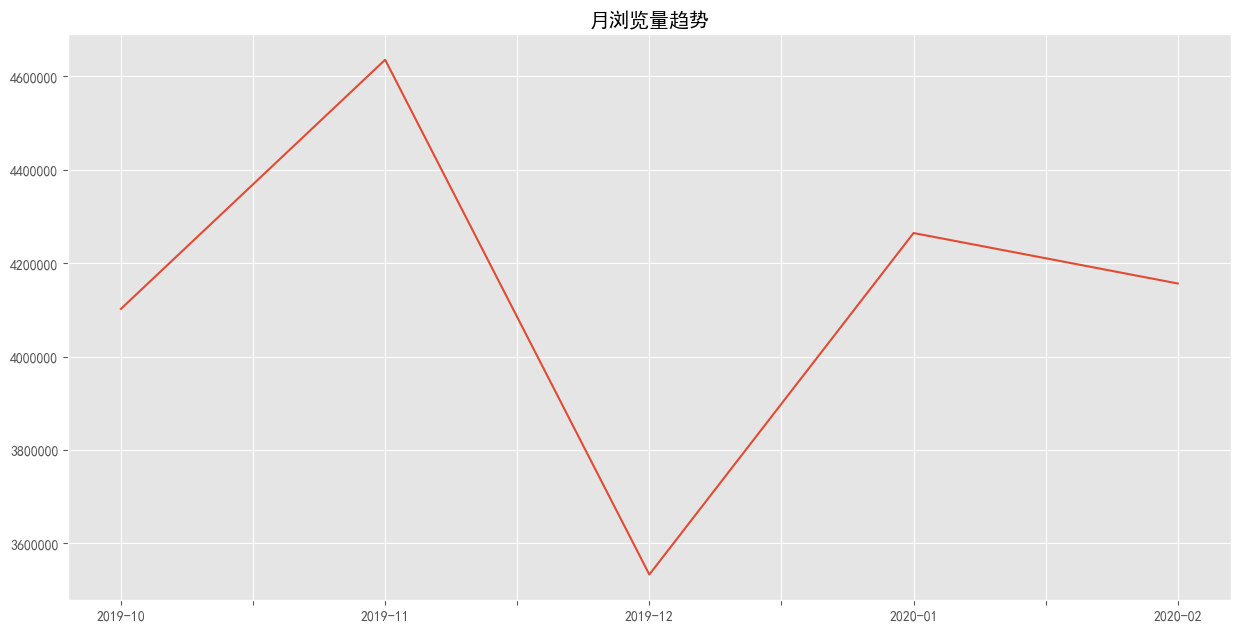

In [12]:
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False 

plt.figure(figsize=(15,7.5),dpi=100)
fig = pv_daily.sort_index().plot()
plt.title('日浏览量趋势')
plt.show()

pv_monthly = df.year_month.value_counts()
plt.figure(figsize=(15,7.5),dpi=100)
fig = pv_monthly.sort_index().plot()
plt.title('月浏览量趋势')
plt.show()


In [13]:
pv_monthly.sort_index()

2019-10    4102283
2019-11    4635837
2019-12    3533286
2020-01    4264752
2020-02    4156682
Name: year_month, dtype: int64

In [14]:
nov = abs((pv_monthly['2019-11']/np.mean(pv_monthly[['2019-10','2020-01','2020-02']])-1)*100)
dec = abs((pv_monthly['2019-12']/np.mean(pv_monthly[['2019-10','2020-01','2020-02']])-1)*100)

In [15]:
print(f'促销活动带来了比平时多{nov:.3f}%的流量，而圣诞节期间快递停运造成的物流时效变长导致了比平时少{dec:.3f}%的流量。')

促销活动带来了比平时多11.049%的流量，而圣诞节期间快递停运造成的物流时效变长导致了比平时少15.362%的流量。


结论：11月22日左右由于黑五活动的原因，页面浏览量达到了五个月中的峰值，而在12月31日左右由于圣诞节放假，快递停运等原因，页面浏览量达到了最低谷。体现在月度数据中即为十一月份电商网站的页面浏览量最高，而十二月份最低。 其他月份则维持在4200k上下的页面浏览量水平，较为稳定。

# 三、电商网站客户访问量分析

## 3.1 客户纬度

In [16]:
df_uv = df[['user_id','date','event_type']].groupby(['user_id','date'],as_index=False).count().rename(columns={'event_type':'count'})
df_uv_count = df_uv.groupby('user_id').sum()
print(df_uv.head())
print(df_uv_count.head())

   user_id        date  count
0   465496  2020-01-14      3
1  1120748  2019-11-04      1
2  1180452  2019-12-28      1
3  1458813  2019-11-19      2
4  1458813  2019-11-20     28
         count
user_id       
465496       3
1120748      1
1180452      1
1458813     31
2038666      1


In [17]:
print('在201910-202002期间，总共有{}位客户访问该网站。'.format(len(df_uv.user_id.unique())))
print('其中访问次数最多的客户为user_id={}，访问了{}次。'.format(df_uv_count.index[df_uv_count['count'].argmax()],max(df_uv_count['count'])))
print('结合前一部分计算的总体页面浏览量为20692840，可以计算得出，人均页面访问量为:%.2f' % (20692840/len(df_uv.user_id.unique())))

在201910-202002期间，总共有1639358位客户访问该网站。
其中访问次数最多的客户为user_id=527021202，访问了26752次。
结合前一部分计算的总体页面浏览量为20692840，可以计算得出，人均页面访问量为:12.62


人均页面访问量可与同类型网站或者行业平均进行比较，来判断自己平台的优劣势。

In [18]:
print('访问量排名前十的客户为：')
print(df_uv_count.sort_values('count',ascending=False).iloc[:10,:])

访问量排名前十的客户为：
           count
user_id         
527021202  26752
557616099   9903
583884978   9420
419558969   8283
476450673   8122
467810091   8066
557956487   7735
550388516   7556
552908674   7419
506877330   6909


In [23]:
uv_count = df_uv_count['count'].copy()
uv_count = uv_count.loc[uv_count<=np.quantile(uv_count,0.99)]

为了更直观的分析客户访问量情况，我们将大于99分位数的访问量视为异常值。为避免极值影响分布图的展示，下图只展示小于99分位数的访问量情况。


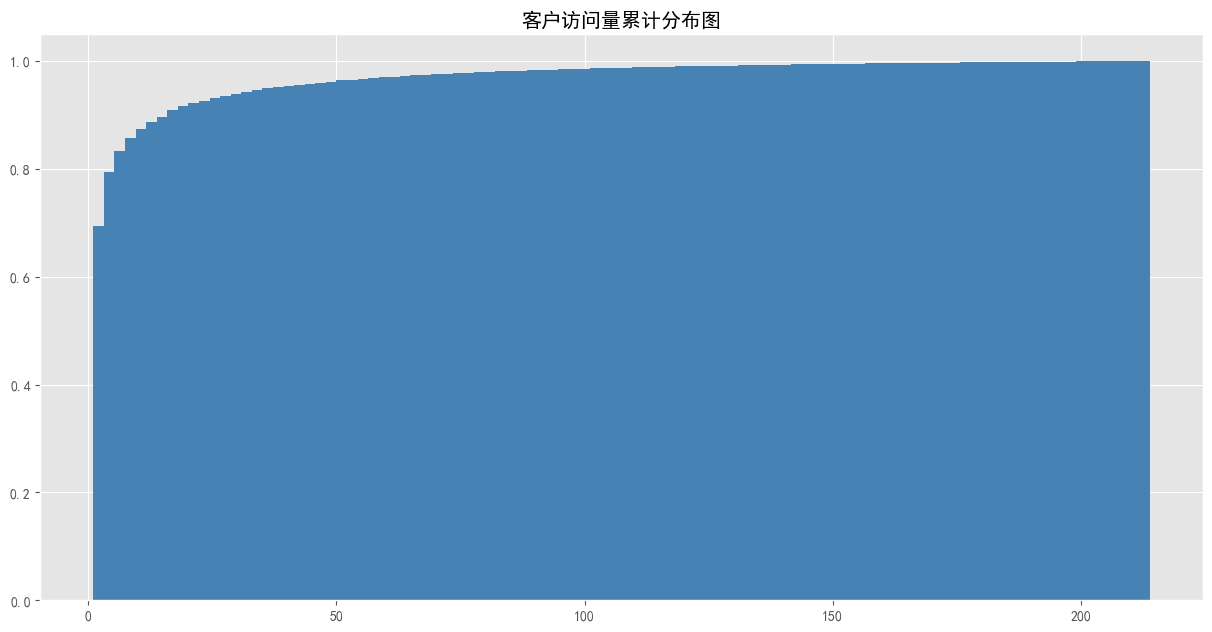

In [20]:
print('为了更直观的分析客户访问量情况，我们将大于99分位数的访问量视为异常值。为避免极值影响分布图的展示，下图只展示小于99分位数的访问量情况。')
plt.figure(figsize=(15,7.5),dpi=100)
plt.hist(uv_count,bins=100,density=True,cumulative=True,color='steelblue')
plt.title('客户访问量累计分布图')
plt.show()

可以看出，绝大多数的客户访问量在五十次以内，平均一月十次以内。

## 3.2 时间维度: 日/月客户量趋势

在此维度下，我们关注客户数量而非客户访问量，即：同一客户在一日之内访问多次仅算作一个客户。

In [24]:
df_uv_date = df_uv[['user_id','date']]
df_uv_date['year_month'] = df_uv['date'].apply(lambda x:x[:7])

In [25]:
uv_daily = df_uv_date.date.value_counts().sort_index()
uv_monthly = df_uv_date.year_month.value_counts().sort_index()

In [26]:
print('日均客户量:',np.mean(uv_daily))
print('日最大客户量:{},日期为:{}'.format(max(uv_daily),uv_daily[uv_daily==max(uv_daily)].index[0]))
print('日最小客户量:{},日期为:{}'.format(min(uv_daily),uv_daily[uv_daily==min(uv_daily)].index[0]))

日均客户量: 18453.315789473683
日最大客户量:33859,日期为:2019-10-02
日最小客户量:7430,日期为:2019-12-31


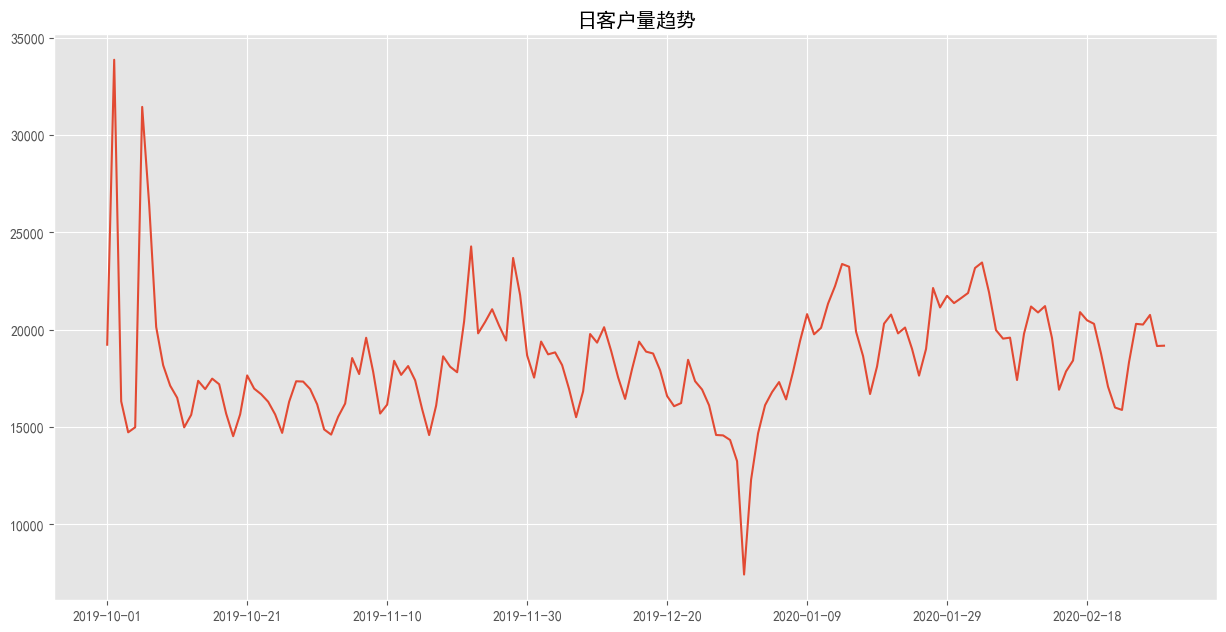

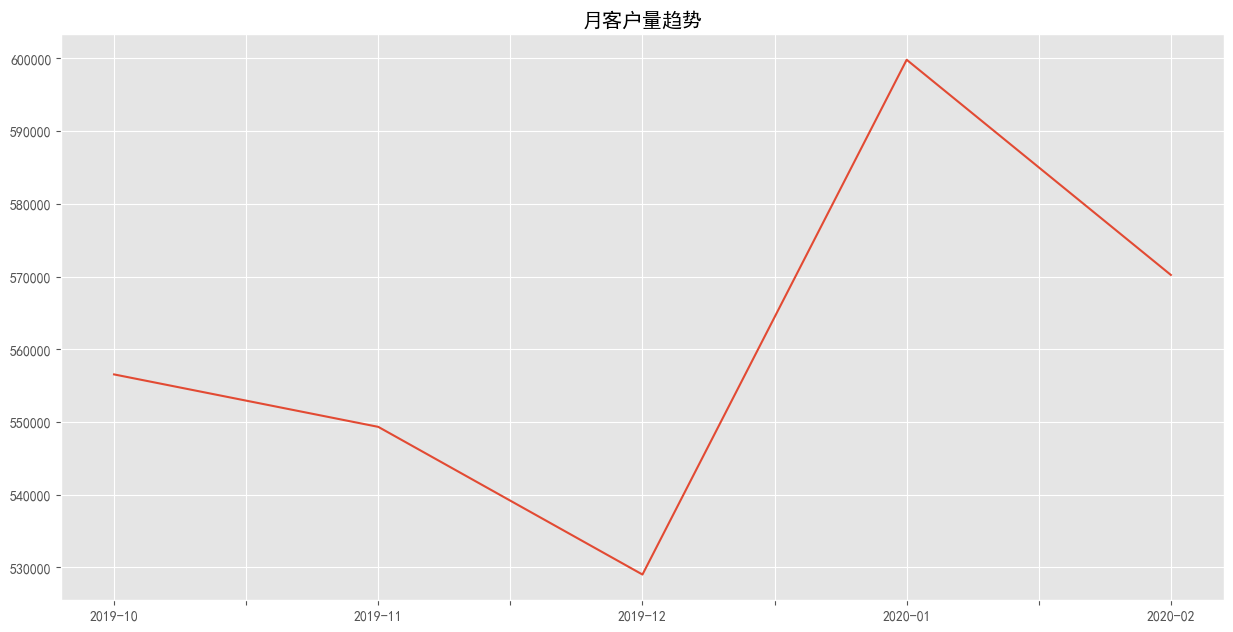

In [27]:
plt.figure(figsize=(15,7.5),dpi=100)
df_uv_date.date.value_counts().sort_index().plot()
plt.title('日客户量趋势')
plt.show()
plt.figure(figsize=(15,7.5),dpi=100)
df_uv_date.year_month.value_counts().sort_index().plot()
plt.title('月客户量趋势')
plt.show()

    从这里可以看出与上一部分的浏览量指标趋势的异同点： 1. 相同点在于，低谷都出现在12.31日，即圣诞节的放假效应使得客户量和总浏览量都有明显下降，说明总浏览量的下降应该是由于客户量下降导致的。 2. 不同点在于，峰值出现的时间不相同。浏览量中很直观地体现出了黑五活动带来的效应，峰值出现在11.22附近，但是客户量的峰值却是出现在十月初，在11.22附近，客户量有小幅上升，但是幅度并不明显。这说明了黑五的浏览量增加并非由客户量上升导致，而是由于活动本身的运营策略导致存量客户的浏览增加。而十月初的时候，该平台应该采用了一些吸引新客户的运营手段，才使得客户量在十月初有明显上升。
    
    同时可以看到，十月的新用户运营策略似乎持久性不长，十月初出现了两次峰值后又回落至较低水平，导致十月一整月的整体客户量并不高，不如2020年1月和2月。2020年1月可以看作是圣诞假期后的报复性消费期，然后到了二月自然回落，但二月仍然有着比去年十月更高的水平。

# 四、漏斗模型：转化率分析

## 4.1 客户加购次数

In [29]:
df_addchart = df[df.event_type == 'cart']

df_addchart_all = df_addchart[['user_id','date','event_type']].groupby(['user_id','date'],as_index=False).count().rename(columns={'event_type':'count'})
df_addchart_all.head()

,user_id,date,count
0,2963072,2019-12-22,7
1,4103071,2019-10-21,1
2,4661182,2019-12-06,1
3,4661182,2019-12-22,1
4,5493470,2019-11-11,5


In [30]:
df_addchart_user = df_addchart_all.groupby('user_id').sum()
max_id = df_addchart_user[df_addchart_user['count']==max(df_addchart_user['count'])].index[0]
print('在201910-202002期间，客户加购总次数为:',sum(df_addchart_user['count']))
print('其中加购次数最多的客户为user_id={}，加购了{}次'.format(max_id,max(df_addchart_user['count'])))
print('1639358位客户中，有{}位客户有过加购行为，人均加购次数为:%.2f'.format(df_addchart_user.shape[0]) % (sum(df_addchart_user['count'])/df_addchart_user.shape[0]))
print('整体客户加购转化率为:{}'.format(df_addchart_user.shape[0]/1639358))

在201910-202002期间，客户加购总次数为: 5768333
其中加购次数最多的客户为user_id=527021202，加购了4292次
1639358位客户中，有398308位客户有过加购行为，人均加购次数为:14.48
整体客户加购转化率为:0.24296584394622772


In [31]:
df_addchart_user = df_addchart_all.groupby('user_id').sum()
print('加购次数排名前十的客户和加购次数分别为:')
print(df_addchart_user.sort_values('count',ascending=False).iloc[:10,:])

加购次数排名前十的客户和加购次数分别为:
           count
user_id         
527021202   4292
445777038   3850
258927307   3651
419558969   3307
399445659   2879
476450673   2735
467810091   2676
562226472   2655
610711289   2641
506877330   2550


## 4.2 日加购量趋势

In [32]:
df_addchart_date = df_addchart_all[['date','count']].groupby('date').sum()
print('日加购量最大为:{},日期为:{}'.format(max(df_addchart_date['count']),df_addchart_date.index[df_addchart_date['count'].argmax()]))
print('日加购量最小为:{},日期为:{}'.format(min(df_addchart_date['count']),df_addchart_date.index[df_addchart_date['count'].argmin()]))

日加购量最大为:89124,日期为:2019-10-02
日加购量最小为:7063,日期为:2019-12-31


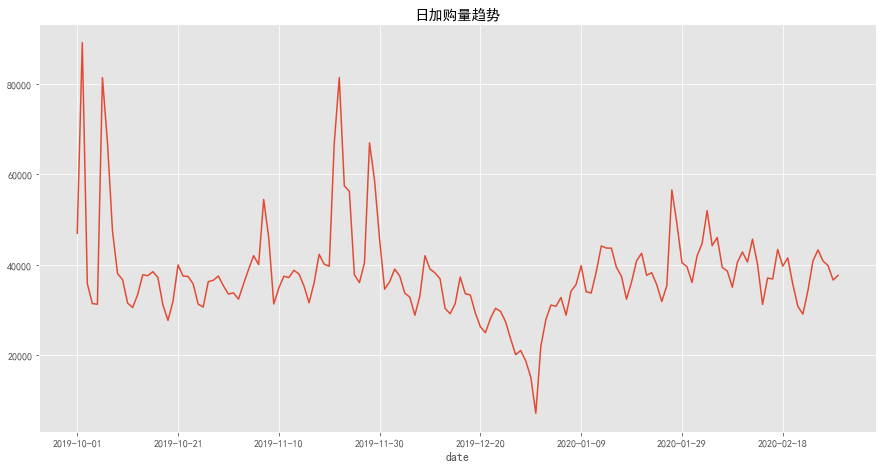

In [33]:
plt.figure(figsize=(15,7.5))
df_addchart_date['count'].plot()
plt.title('日加购量趋势')
plt.show()

## 4.3 日客户加购转化率

首先，明确日客户加购转化率的定义：以天为周期，一个客户在周期内多次浏览仅算做一次（unique visitor），如果客户在周期内作出了加购行为（多次或一次），仅算做一次加购。

In [34]:
df_addchart_date = df_addchart_all[['user_id','date']]

In [40]:
#计算每日客户数量
uv = df_uv_date.groupby('date',as_index=False).count()
#计算每日加购数量
addchart = df_addchart_date.groupby('date',as_index=False).count()  

uv_addchart = pd.merge(uv[['date','user_id']],addchart,on='date')
uv_addchart['conversion_rate'] = uv_addchart.iloc[:,2]/uv_addchart.iloc[:,1]

In [41]:
print('日均客户加购转化率为:',np.mean(uv_addchart['conversion_rate']))
print('日最大加购转化率为:{},日期是:{}'.format(max(uv_addchart['conversion_rate']),uv_addchart['date'][uv_addchart['conversion_rate'].argmax()]))
print('日最小加购转化率为:{},日期是:{}'.format(min(uv_addchart['conversion_rate']),uv_addchart['date'][uv_addchart['conversion_rate'].argmin()]))

日均客户加购转化率为: 0.25676330085648513
日最大加购转化率为:0.6536814436338935,日期是:2019-10-02
日最小加购转化率为:0.1468371467025572,日期是:2019-12-31


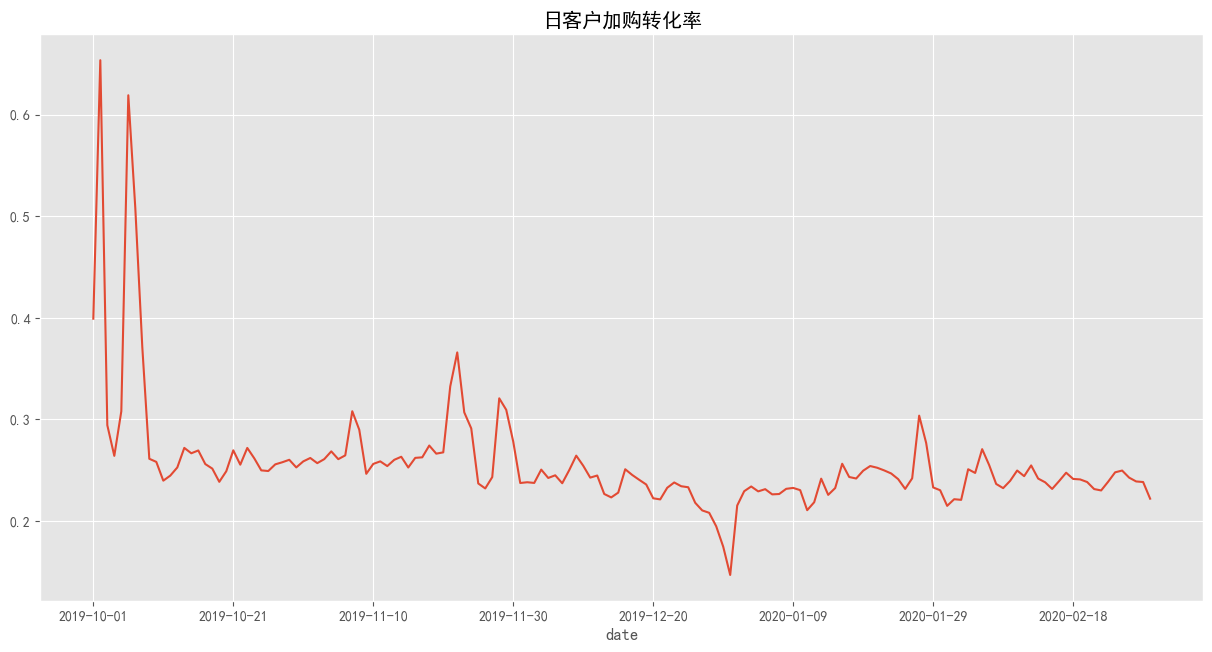

In [42]:
plt.figure(figsize=(15,7.5),dpi=100)
uv_addchart[['date','conversion_rate']].set_index('date')['conversion_rate'].plot()
plt.title('日客户加购转化率')
plt.show()

    上图可以看出，加购转化率在十月初超过了百分之六十，远远高于平均水平，说明十月初的新客户吸引策略中应该包含了一些折扣策略，使得客户离购买更近了一步，新客户被折扣吸引后大大提高了加购率。十月份整个的加购率水平要高于后续月份，结合之前客户人数的分析，十月的客户人数比来年一月和二月要低，但是前者加购转化率却略高于后者，说明前者的客户群体里对产品有加购意愿的人群占比应该要高于后者。应该是新客户运营策略的结果。
    
    黑五期间，加购数量也出现了峰值，但是加购转化率的增加幅度远不及十月初，这说明，黑五期间是存量客户多次加购导致的加购量高，在客户量上并没有太高的提升，这也说明了十月初的加购量大是由于新用户增加导致的，而非加购次数多导致的。
   


## 4.4 客户购买次数

In [43]:
df_purchase = df[df.event_type == 'purchase']

In [44]:
df_purchase_all= df_purchase[['user_id','date','event_type']].groupby(['user_id','date'],as_index=False).count().rename(columns={'event_type':'count'})

In [45]:
df_purchase_user = df_purchase_all.groupby('user_id').sum()
max_id = df_purchase_user[df_purchase_user['count']==max(df_purchase_user['count'])].index[0]
print('在201910-202002期间，客户购买总次数为:',sum(df_purchase_user['count']))
print('其中购买次数最多的客户为user_id={}，购买了{}次'.format(max_id,max(df_purchase_user['count'])))
print('398308位客户中，有{}位客户有过购买行为，人均购买次数为:%.2f'.format(df_purchase_user.shape[0]) % (sum(df_purchase_user['count'])/df_purchase_user.shape[0]))
print('整体客户加购至购买转化率为:{}'.format(df_purchase_user.shape[0]/398308))

在201910-202002期间，客户购买总次数为: 1287007
其中购买次数最多的客户为user_id=480463194，购买了715次
398308位客户中，有110518位客户有过购买行为，人均购买次数为:11.65
整体客户加购至购买转化率为:0.2774686925695693


In [46]:
df_purchase_user = df_purchase_all.groupby('user_id').sum()
print('加购次数排名前十的客户和加购次数分别为:')
print(df_purchase_user.sort_values('count',ascending=False).iloc[:10,:])

加购次数排名前十的客户和加购次数分别为:
           count
user_id         
480463194    715
469299888    603
556579890    506
381816972    500
601469771    461
557790271    438
473313149    417
517825140    412
247216055    409
566439116    409


## 4.5 日购买量趋势

In [47]:
df_purchase_date = df_purchase_all[['date','count']].groupby('date').sum()
print('日购买量最大为:{},日期为:{}'.format(max(df_purchase_date['count']),df_purchase_date.index[df_purchase_date['count'].argmax()]))
print('日购买量最小为:{},日期为:{}'.format(min(df_purchase_date['count']),df_purchase_date.index[df_purchase_date['count'].argmin()]))

日购买量最大为:22780,日期为:2019-11-22
日购买量最小为:1126,日期为:2019-12-31


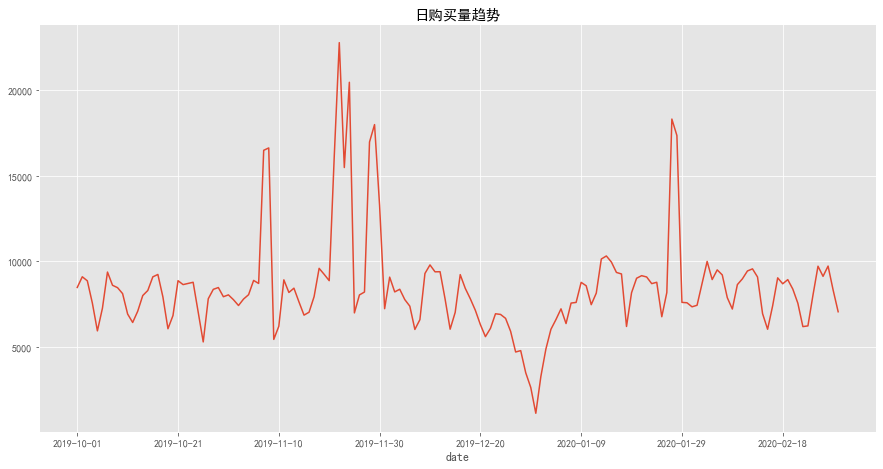

In [48]:
plt.figure(figsize=(15,7.5))
df_purchase_date['count'].plot()
plt.title('日购买量趋势')
plt.show()

## 4.6 日客户加购至购买转化率

明确日客户加购至购买转化率的定义：以天为周期，一个客户在周期内多次加购仅算做一次（unique visitor），如果客户在周期内作出了购买行为（多次或一次），仅算做一次购买。

In [49]:
df_purchase_date = df_purchase_all[['user_id','date']]

In [50]:
#计算每日购买数量
purchase = df_purchase_date.groupby('date',as_index=False).count()  

addchart_purchase = pd.merge(addchart,purchase,on='date')
addchart_purchase['conversion_rate'] = addchart_purchase.iloc[:,2]/addchart_purchase.iloc[:,1]

In [51]:
print('日均客户加购至购买转化率为:',np.mean(addchart_purchase['conversion_rate']))
print('日最大加购至购买转化率为:{},日期是:{}'.format(max(addchart_purchase['conversion_rate']),addchart_purchase['date'][addchart_purchase['conversion_rate'].argmax()]))
print('日最小加购至购买转化率为:{},日期是:{}'.format(min(addchart_purchase['conversion_rate']),addchart_purchase['date'][addchart_purchase['conversion_rate'].argmin()]))

日均客户加购至购买转化率为: 0.21699656791517016
日最大加购至购买转化率为:0.3450075770331706,日期是:2019-11-24
日最小加购至购买转化率为:0.0428439330114045,日期是:2019-10-06


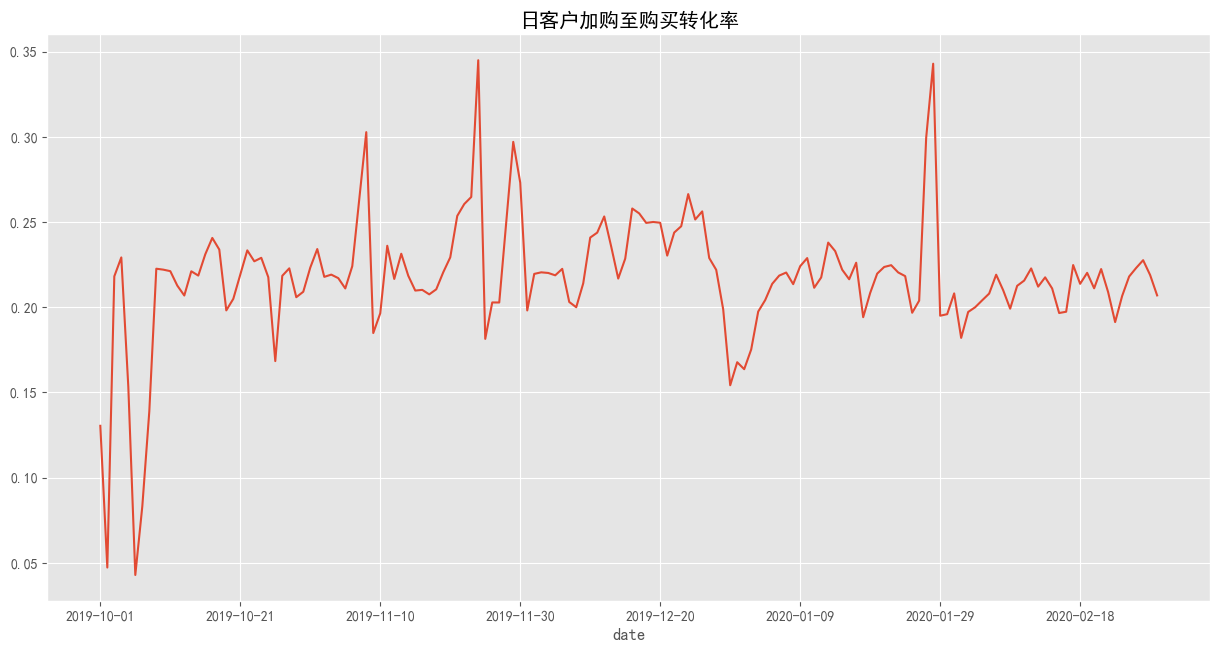

In [52]:
plt.figure(figsize=(15,7.5),dpi=100)
addchart_purchase[['date','conversion_rate']].set_index('date')['conversion_rate'].plot()
plt.title('日客户加购至购买转化率')
plt.show()

    从购买量和加购至购买转化率来看，十月初的新用户策略并没有带来购买量的提升，新客户被吸引只到加购这一步有明显的效果，但在最终的购买决策时却没有达到很好的效果。由于加购量大，而购买量却没有显著提升，导致十月初的加购至购买转化率明显低于其他时间。
    而黑五期间，达到了很好的购买量和客户购买转化率，这说明存量客户对与最终的销售额有着更大的作用。

# 五、客户总体消费情况分析

In [53]:
data_alls_purchase = df_purchase

## 5.1 五个月的销售总体指标

In [54]:
#求出销售总金额、总单数、总用户数
all_amount=data_alls_purchase.price.sum()
all_count=data_alls_purchase.price.count()
all_customers=len(data_alls_purchase.user_id.drop_duplicates())

print('{:*^30}'.format('销售总指标'))
print('销售总金额:',all_amount)
print('销售总单数:',all_count)
print('购买总人数:',all_customers)

************销售总指标*************
销售总金额: 6351830.289999997
销售总单数: 1287007
购买总人数: 110518


## 5.2 客户每月消费趋势

In [55]:
#求出销售总金额、总单数、总人数的月趋势
month_amount=data_alls_purchase.price.sum()/5
month_count=data_alls_purchase.price.count()/5
month_customers=len(data_alls_purchase.user_id.drop_duplicates())/5

print('{:*^30}'.format('月均销售指标'))
print('月均销售总金额:',month_amount)
print('月均销售总单数:',month_count)
print('月均购买总人数:',month_customers)

************月均销售指标************
月均销售总金额: 1270366.0579999995
月均销售总单数: 257401.4
月均购买总人数: 22103.6


Text(0.5, 1.0, '每月人均消费金额')

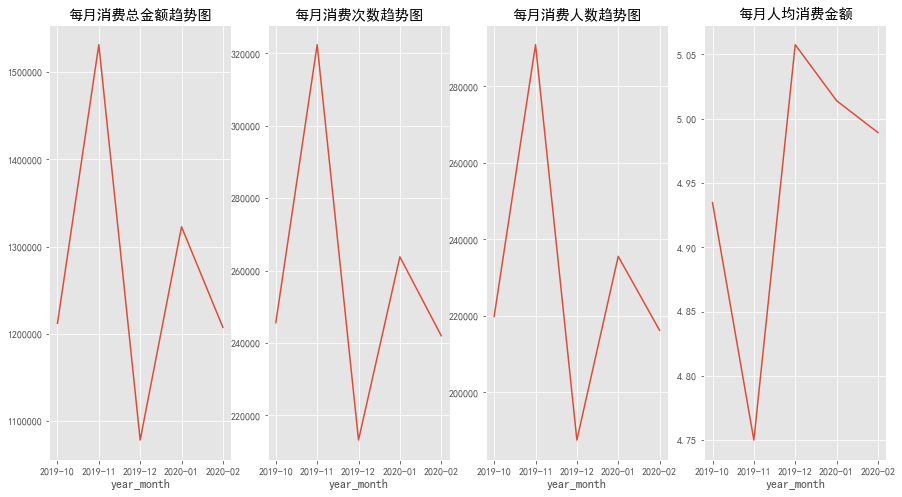

In [56]:
fig,axes=plt.subplots(1,4,figsize=(15,8))
ax1=axes[0]
ax2=axes[1]
ax3=axes[2]
ax4=axes[3]

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

#作出客户每月消费金额趋势图
data_alls_purchase.groupby('year_month').price.sum().plot(ax=ax1)
ax1.set_title('每月消费总金额趋势图')

#作出客户每月消费次数趋势图
data_alls_purchase.groupby('year_month').event_time.count().plot(ax=ax2) 
ax2.set_title('每月消费次数趋势图')

#求出每个月不重复user_id的数量
def get_month_unique(data):
    a=data.duplicated()
    return a.value_counts()
data_month_unique_user=data_alls_purchase.groupby(['year_month']).user_id.apply(get_month_unique)

#False表示不重复的ID数
data_month_unique_user=data_month_unique_user.unstack()

#作出每月消费人数的趋势图
data_month_unique_user.iloc[:,0].plot(ax=ax3)
ax3.set_title('每月消费人数趋势图')

#每月人均消费金额
every_person_consume = data_alls_purchase.groupby('year_month').price.sum() / data_month_unique_user.unstack().groupby('year_month').sum()
every_person_consume.plot(ax=ax4)
ax4.set_title('每月人均消费金额')

## 5.3 结论

从这几方面的数据来看，2019-10到2020-02这五个月消费情况变化较大是在2019-11月中，首先推断是由于黑五活动的影响，而获益于黑五活动的影响，消费总额、消费次数、消费人数都提高了，但人均消费却是最低。

# 六、客户个体消费情况分析

## 6.1 人均消费金额与消费次数

In [57]:
#求出人均消费金额、人均消费次数、人均每单消费
user_comsumption=data_alls_purchase.groupby('user_id').price.sum()
user_count=data_alls_purchase.groupby('user_id').price.count()

#人均消费金额与人均消费次数
data_user_average=data_alls_purchase.pivot_table(index='user_id',values=['price','event_time'],aggfunc={'price':'sum','event_time':'count'})
#人均每单消费金额
data_user_average['amount']=data_user_average['price']/data_user_average['event_time']

data_user_average.describe()

,event_time,price,amount
count,110518.000000,110518.000000,110518.000000
mean,11.645225,57.473265,8.097628
std,18.265518,88.639681,13.216326
min,1.000000,0.130000,0.130000
25%,3.000000,16.270000,3.256446
50%,6.000000,33.220000,4.871022
75%,13.000000,61.580000,7.940000
max,715.000000,3785.030000,299.810000


Text(0.5, 1.0, '人均购买量趋势图')

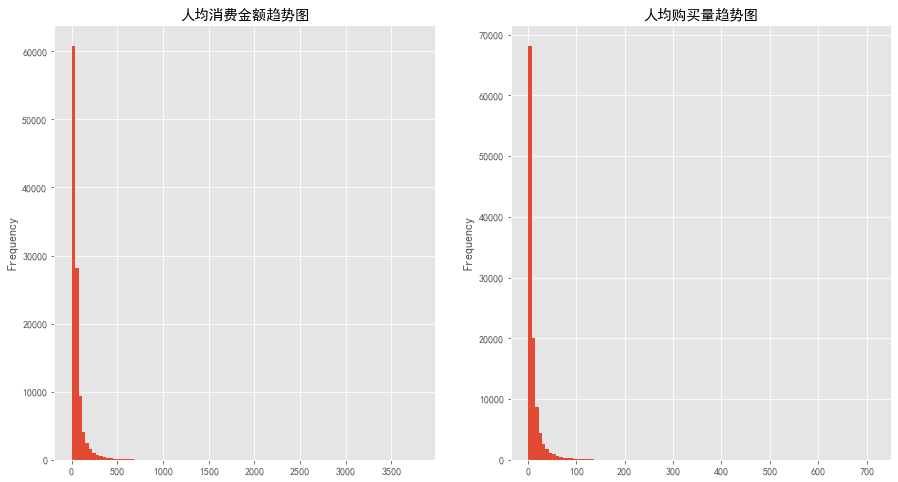

In [58]:
fig,axes=plt.subplots(1,2,figsize=(15,8))
ax1=axes[0]
ax2=axes[1]

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

#作出客户人均消费金额趋势图
user_comsumption.plot.hist(bins=100,ax=ax1)
ax1.set_title('人均消费金额趋势图')

#作出客户人均消费次数趋势图
user_count.plot.hist(bins=100,ax=ax2)
ax2.set_title('人均购买量趋势图')

一共110518个客户，在消费次数上看，趋势是集中消费（少部分多消费），在消费金额上看，五个月总人均消费为57.473265，差不多75%的人低于平均值，而std、min和max的区别这里可以看到客户的个体差异非常大，逐步推断是二八法则，下面作出消费金额二八法则图。

          user_id    price  comsumption_amount      prop
110513  469299888  2934.13          6338690.00  0.997931
110514  471197852  2938.91          6341628.91  0.998394
110515  562167663  2969.45          6344598.36  0.998861
110516  531900924  3446.90          6348045.26  0.999404
110517  150318419  3785.03          6351830.29  1.000000


Text(0, 0.5, '消费金额占总金额比例')

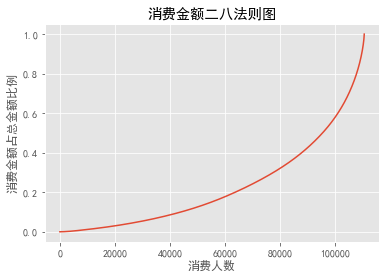

In [59]:
#作出消费金额二八法则图
user_comsumption = data_alls_purchase.groupby('user_id')['price'].sum().sort_values().reset_index()  # 升序并保留原行索引
user_comsumption['comsumption_amount'] = user_comsumption['price'].cumsum()  # 累加
comsumption_amount_total = user_comsumption['comsumption_amount'].max()
user_comsumption['prop'] = user_comsumption.apply(lambda x: x.comsumption_amount / comsumption_amount_total, axis=1) #转换成百分比
print(user_comsumption.tail()) #输出后5行
user_comsumption.prop.plot() #可视化（用户数和贡献金额的关系）
plt.title('消费金额二八法则图')
plt.xlabel('消费人数')
plt.ylabel('消费金额占总金额比例')

Text(0, 0.5, '消费人数占总用户人数比例')

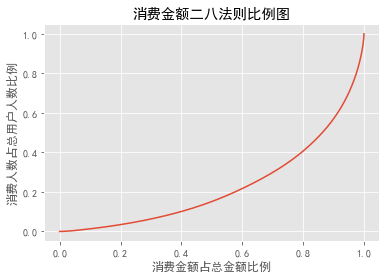

In [60]:
#作出消费金额比例二八法则图
data_user=data_alls_purchase.groupby('user_id').price.sum().sort_values().reset_index()
user_sort=data_user['price'].cumsum()/data_user['price'].sum()
index=user_sort.index/len(user_sort)
user_sort.index=index
user_sort.plot()

plt.title('消费金额二八法则比例图')
plt.xlabel('消费金额占总金额比例')
plt.ylabel('消费人数占总用户人数比例')


每月人均消费金额： year_month
2019-10    5.512976
2019-11    5.264853
2019-12    5.748279
2020-01    5.614700
2020-02    5.583620
dtype: float64
每月人均消费次数: year_month
2019-10    1.117173
2019-11    1.108370
2019-12    1.136557
2020-01    1.119791
2020-02    1.119126
dtype: float64
每月客单价: year_month
2019-10    5.512976
2019-11    5.264853
2019-12    5.748279
2020-01    5.614700
2020-02    5.583620
dtype: float64


Text(0.5, 1.0, '每月客单价趋势图')

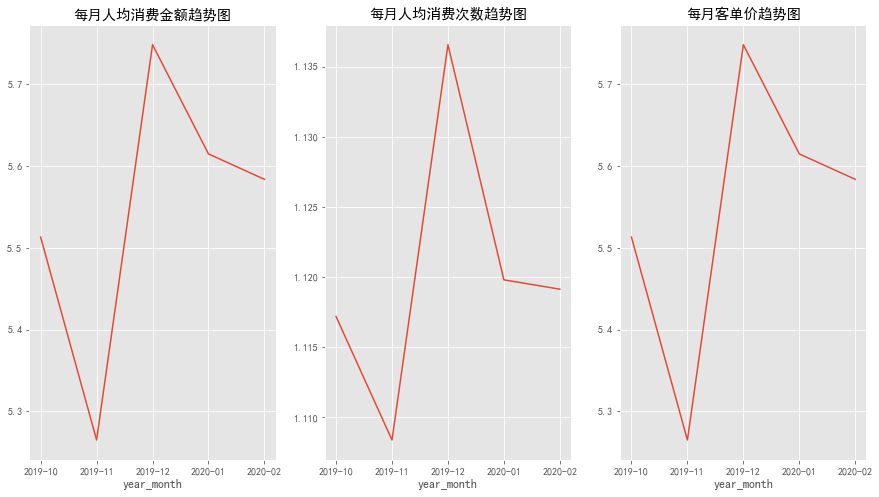

In [61]:
#人均消费趋势
fig,axes=plt.subplots(1,3,figsize=(15,8))
ax4=axes[0]
ax5=axes[1]
ax6=axes[2]

#作出每月人均消费金额的趋势图
print('每月人均消费金额：',data_alls_purchase.groupby('year_month')['price'].sum()/data_month_unique_user.iloc[:,0])
(data_alls_purchase.groupby('year_month')['price'].sum()/data_month_unique_user.iloc[:,0]).plot(ax=ax4)
ax4.set_title('每月人均消费金额趋势图')

#作出每月人均消费次数的趋势图
print('每月人均消费次数:',data_alls_purchase.groupby('year_month')['user_id'].count()/data_month_unique_user.iloc[:,0])
(data_alls_purchase.groupby('year_month')['user_id'].count()/data_month_unique_user.iloc[:,0]).plot(ax=ax5)
ax5.set_title('每月人均消费次数趋势图')

#作出每月客单价的趋势图
print('每月客单价:',data_alls_purchase.groupby('year_month')['price'].sum()/data_month_unique_user.iloc[:,0])
(data_alls_purchase.groupby('year_month')['price'].sum()/data_month_unique_user.iloc[:,0]).plot(ax=ax6)
ax6.set_title('每月客单价趋势图')

## 6.2 结论

从图上可以看到40%左右的客户贡献的80%的销售额，购买力并不集中，每月人均消费是5.5 dollar 左右且每月人均购买次数是1次，都是非常低的，销售额受到人数流入流出的影响比较大，这样的商店需要更加关注新增人数和留存。

# 七、客户消费行为分析

以天为单位,从时间分布，重要购物行为以及 消费产品的特性去分析客户消费行为来了解客户

## 7.1 购物时间分布情况

Text(0.5, 1.0, '客户每天消费金额趋势图')

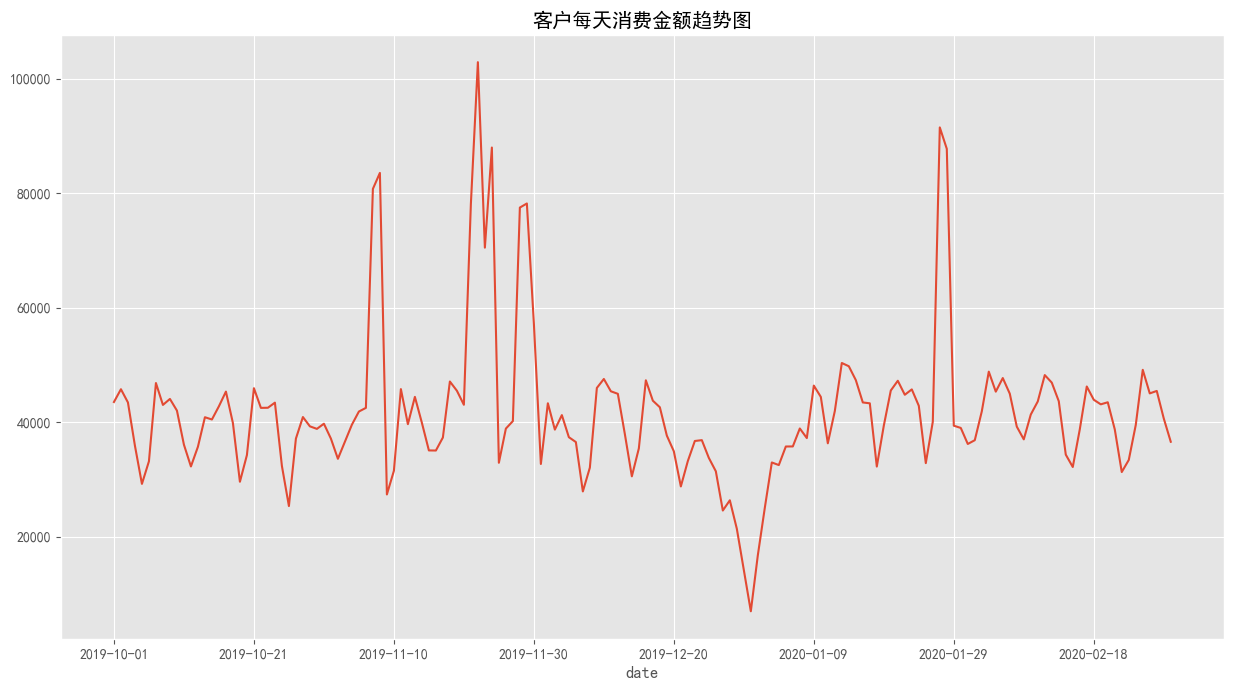

In [62]:
#查看客户消费金额在时间(每天)上的分布图
plt.figure(figsize=(15,8),dpi=100)
data_alls_date=data_alls_purchase.groupby('date')['price'].sum()
data_alls_date.plot()
plt.title('客户每天消费金额趋势图')

In [63]:
#查看客户消费金额的描述统计情况
data_alls_date.describe() 

count       152.000000
mean      41788.357171
std       13396.786525
min        6987.740000
25%       35638.750000
50%       39982.440000
75%       44989.647500
max      102854.760000
Name: price, dtype: float64

In [64]:
#查看消费金额最大值的日期
data_alls_date.idxmax()

'2019-11-22'

In [65]:
#查看消费金额最小值的日期
data_alls_date.idxmin()

'2019-12-31'

In [66]:
#查看消费金额前十名的日期
first_ten_date = data_alls_date.sort_values(ascending=False)[:10]
first_ten_date

date
2019-11-22    102854.76
2020-01-27     91467.28
2019-11-24     87953.90
2020-01-28     87725.65
2019-11-08     83522.43
2019-11-07     80731.96
2019-11-29     78182.87
2019-11-21     78108.62
2019-11-28     77470.54
2019-11-23     70471.66
Name: price, dtype: float64

In [67]:
#查看消费金额后十名的日期
last_ten_date = data_alls_date.sort_values(ascending=False)[-10:]
last_ten_date

date
2019-12-07    27908.62
2019-11-09    27384.52
2019-12-28    26363.85
2019-10-26    25359.18
2020-01-02    25067.09
2019-12-27    24575.93
2019-12-29    21391.92
2020-01-01    16765.95
2019-12-30    14237.95
2019-12-31     6987.74
Name: price, dtype: float64

可以看到客户消费情况在均值附近波动，如有强大波动则是运营活动作用的结果；
消费金额最大值大部分都分布在黑五附近，黑五之前平台就开始实施了营销活动方案。
金额最小值在2019-12-31日，且靠近该日期附近的一个星期的消费金额都处于下降趋势，这是因为圣诞节开始，人们都开始过节，消费金额可能更多的倾向于其他产品，比如食品、礼物等，从而导致客户的化妆品上的消费能力下降。

## 7.2 重要消费行为分析

### 7.2.1 首购与最后购

            date
2019-10-01  1001
2019-10-02  1035
2019-10-03  1032
2019-10-04   863
2019-10-05   679
2019-10-06   802
2019-10-07  1057
2019-10-08   978
2019-10-09   976
2019-10-10   904


Text(0.5, 1.0, '每日首购用户人数趋势图')

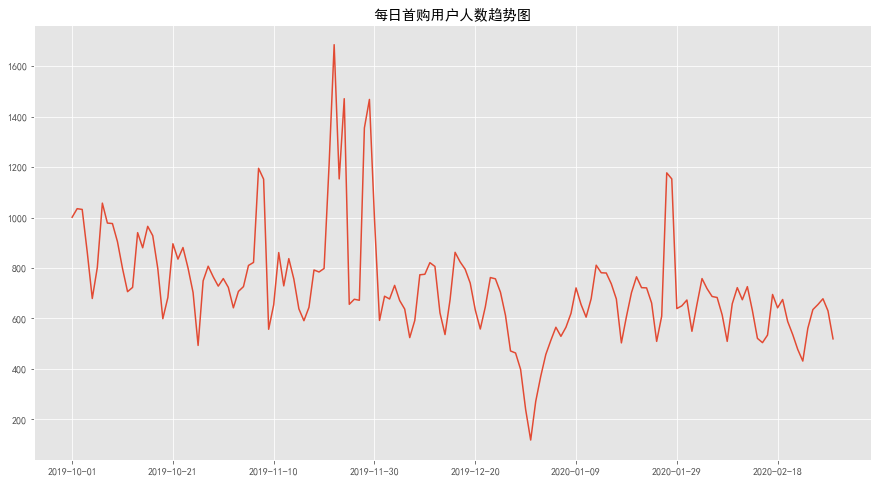

In [68]:
#客户首购时间分布情况
user_first_buy=pd.DataFrame(data_alls_purchase.groupby('user_id').date.min().value_counts()).sort_index()
print(user_first_buy[:10])
plt.figure(figsize=(15,8))
user_first_buy.date.plot()
plt.title('每日首购用户人数趋势图')

            date
2019-10-01   618
2019-10-02   630
2019-10-03   654
2019-10-04   562
2019-10-05   441
2019-10-06   508
2019-10-07   679
2019-10-08   627
2019-10-09   645
2019-10-10   620


Text(0.5, 1.0, '每日最后一次购物用户人数趋势图')

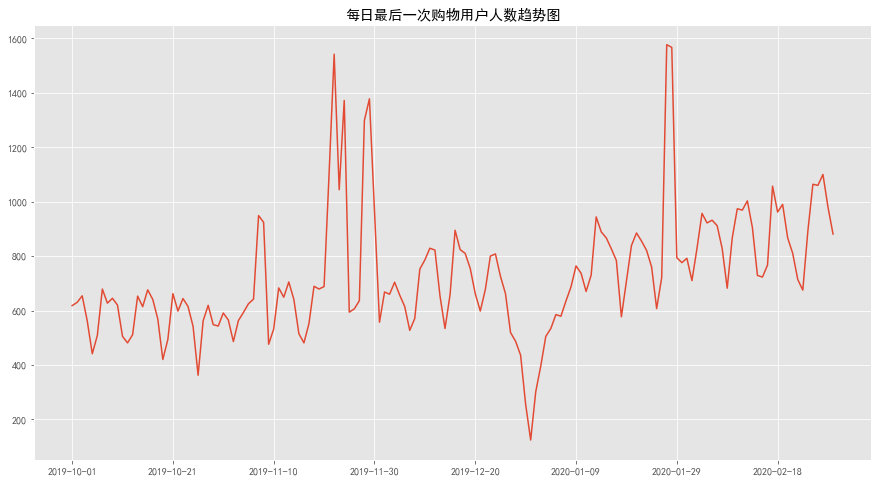

In [69]:
#客户最后一次购物时间分布
user_last_buy = pd.DataFrame(data_alls_purchase.groupby('user_id').date.max().value_counts()).sort_index()
print(user_last_buy[:10])
plt.figure(figsize=(15,8))
user_last_buy.date.plot()
plt.title('每日最后一次购物用户人数趋势图')

Text(0.5, 1.0, '用户首购与最后一次购物趋势图')

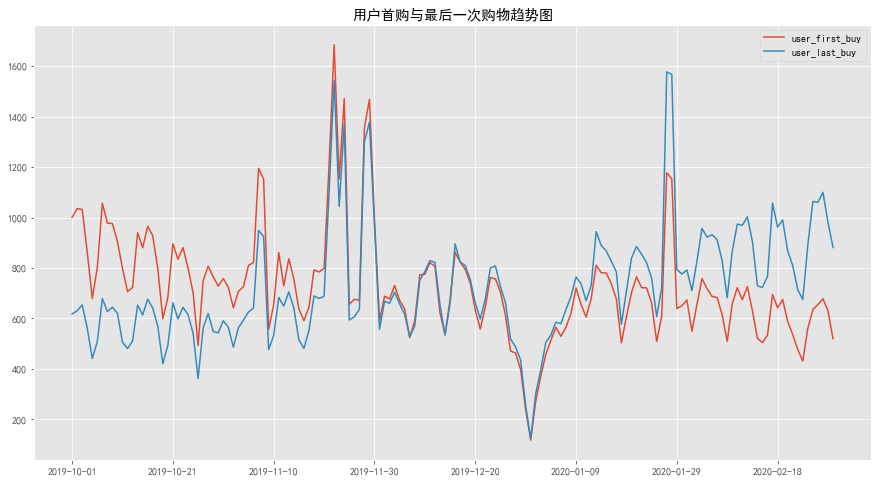

In [70]:
#将两者绘制在同一张图中
fig,ax=plt.subplots(figsize=(15,8))
#plt.plot(user_first_buy,color='blue')
#plt.plot(user_last_buy,color='red')
#pylab.xticks([i for i in range(1,user_first_buy.shape[0]+1,10)],pd.date_range(user_first_buy.index[0],user_first_buy.index[-1],freq='10d'))
#fig.autofmt_xdate()#自动调整xtick的间距
user_first_buy.date.plot(label='user_first_buy')
user_last_buy.date.plot(label='user_last_buy')
plt.legend()
plt.title('用户首购与最后一次购物趋势图')

可以发现首购与最后一次购物时间的分布图趋势几乎完全相似，这里面重叠了很多客户首购就是最后一次购买.

In [71]:
#将首次购物即为最后一次购物的客户挑出来
user_first=data_alls_purchase.groupby('user_id').date.min().reset_index() 
user_last=data_alls_purchase.groupby('user_id').date.max().reset_index() 
user_first_last=pd.merge(user_first,user_last,left_on='user_id',right_on='user_id',how='outer')
user_first_last.columns=['user_id','last','first']
comparison=[]
for i in np.arange(len(user_first_last)):
    comparison.append(user_first_last['first'].iloc[i]==user_first_last['last'].iloc[i])
user_first_last['comparison']=comparison

In [72]:
#查看第一次购物时间跟最后一次购物时间相同的客户数情况
user_first_last['comparison'].value_counts()

True     87780
False    22738
Name: comparison, dtype: int64

In [73]:
#查看五个月时间里只购买一天就流失的客户占比情况
user_first_last.comparison.value_counts()/len(user_first_last)

True     0.79426
False    0.20574
Name: comparison, dtype: float64

In [74]:
user_first_last

,user_id,last,first,comparison
0,9794320,2019-11-25,2019-11-25,True
1,10079204,2019-11-06,2019-11-06,True
2,10280338,2019-11-20,2020-02-19,False
3,12055855,2019-12-20,2019-12-20,True
4,12936739,2020-01-17,2020-01-17,True
...,...,...,...,...
110513,622065819,2020-02-29,2020-02-29,True
110514,622066161,2020-02-29,2020-02-29,True
110515,622067983,2020-02-29,2020-02-29,True
110516,622069477,2020-02-29,2020-02-29,True


Text(0.5, 1.0, '用户首购即为最后一次购物趋势图')

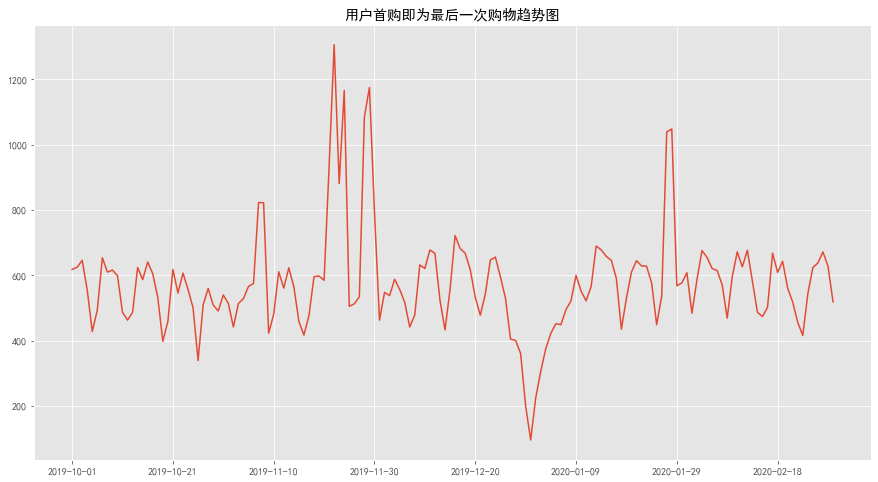

In [75]:
plt.figure(figsize=(15,8))
user_first_last[user_first_last['comparison']==True]['last'].value_counts().sort_index().plot()
plt.title('用户首购即为最后一次购物趋势图')

Text(0.5, 1.0, '用户首购、最后一次购物、一次性购物流失时间分布图')

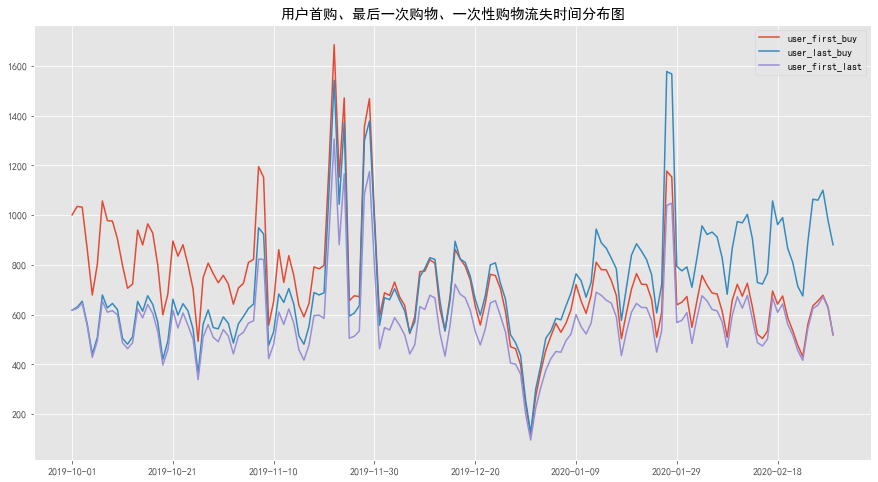

In [76]:
#接下来再看这些客户是在哪里流失的。
#把客户首购的时间分布图、客户最后一次购物的时间分布图、客户五个月一次性购物就流失的时间分布图绘制在一起。

fig,ax=plt.subplots(figsize=(15,8))
user_first_buy.date.plot(label='user_first_buy')
user_last_buy.date.plot(label='user_last_buy')
user_first_last[user_first_last['comparison']==True]['last'].value_counts().sort_index().plot(label='user_first_last')
plt.legend()
plt.title('用户首购、最后一次购物、一次性购物流失时间分布图')

三者数据极其的相似，基本上流失的客户就是新增的客户，当天流入当天流失，流失比较严重

再看一天购买流失客户与不是一天购买流失客户的消费能力对比，稍微验证价格是不是导致客户流失的原因

In [77]:
user_lost_ing=pd.merge(data_alls_purchase[['user_id','price']],user_first_last[['user_id','comparison']],left_on='user_id',right_on='user_id',how='outer')
user_lost=user_lost_ing[user_lost_ing.comparison==True]
user_lost

,user_id,price,comparison
170,579950721,6.19,True
171,579950721,2.62,True
172,579950721,2.38,True
173,579950721,3.97,True
174,579950721,2.78,True
...,...,...,...
1287002,604470329,10.32,True
1287003,604470329,1.90,True
1287004,604470329,11.43,True
1287005,604470329,4.76,True


In [78]:
user_lost_desc=user_lost.groupby('user_id').price.agg(['sum','count'])
user_lost_desc['amount']= user_lost_desc['sum']/ user_lost_desc['count']
user_lost_desc

,sum,count,amount
user_id,,,
9794320,12.68,4,3.170000
10079204,25.81,2,12.905000
12055855,16.54,4,4.135000
12936739,29.89,2,14.945000
15400971,35.71,3,11.903333
...,...,...,...
622065819,20.48,4,5.120000
622066161,12.95,4,3.237500
622067983,66.48,10,6.648000


In [79]:
#查看一天购买流失客户的消费能力情况
user_lost_desc.describe()

,sum,count,amount
count,87780.000000,87780.000000,87780.000000
mean,37.677775,7.309968,8.663726
std,43.667437,8.861312,14.383062
min,0.130000,1.000000,0.130000
25%,14.210000,2.000000,3.226667
50%,25.700000,5.000000,4.976667
75%,45.870000,9.000000,8.573333
max,1566.810000,324.000000,299.810000


In [80]:
#查看不是一天购买流失客户的消费能力情况
user_ing=user_lost_ing[user_lost_ing.comparison!=True]
user_ing_desc=user_ing.groupby('user_id').price.agg(['sum','count'])
user_ing_desc['amount']= user_ing_desc['sum']/ user_ing_desc['count']
user_ing_desc.describe()

,sum,count,amount
count,22738.000000,22738.000000,22738.000000
mean,133.893709,28.381476,5.912209
std,153.216948,31.077960,6.659489
min,0.800000,2.000000,0.295000
25%,49.380000,10.000000,3.345030
50%,89.720000,19.000000,4.560217
75%,160.255000,35.000000,6.467670
max,3785.030000,715.000000,299.810000


### 7.2.2 复购与回购

In [81]:
#查看每月的复购率
user_month_count=data_alls_purchase.pivot_table(index='user_id',columns='year_month',values='event_time',aggfunc='count')
user_month_count=user_month_count.applymap(lambda x:0 if x==1 else 1 if x>1 else np.nan)
user_month_count.sum()/user_month_count.count()

year_month
2019-10    0.905364
2019-11    0.914319
2019-12    0.886386
2020-01    0.907158
2020-02    0.900268
dtype: float64

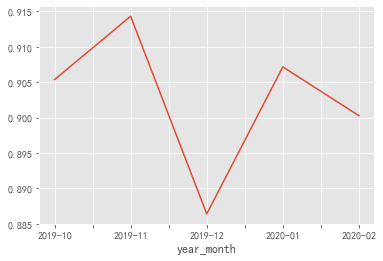

In [82]:
(user_month_count.sum()/user_month_count.count()).plot()

In [83]:
(user_month_count.sum()/user_month_count.count()).mean()

0.902699094068747

In [84]:
user_month_counts=data_alls_purchase.pivot_table(index='user_id',columns='year_month',values='event_time',aggfunc='count').fillna(0)
user_month_counts_pivoted = user_month_counts.applymap(lambda x:1 if x>0 else 0)
user_month_counts_pivoted

year_month,2019-10,2019-11,2019-12,2020-01,2020-02
user_id,,,,,
9794320,0,1,0,0,0
10079204,0,1,0,0,0
10280338,0,1,0,1,1
12055855,0,0,1,0,0
12936739,0,0,0,1,0
...,...,...,...,...,...
622065819,0,0,0,0,1
622066161,0,0,0,0,1
622067983,0,0,0,0,1


In [85]:
#查看回购率
def get_user_next_buy(data):
    status=[]
    #根据月个数写出循环次数
    for i in range(4):
    #对本月进行消费判断
    #1.本月没有消费
        if data[i]==0:
            status.append(np.nan)
    #2.本月有消费
        else:
            #下个月有消费
            if data[i+1] == 1:
                status.append(1)
            #下个月没有消费
            else:
                status.append(0)

    status.append(np.NaN)
    return data

In [86]:
user_month_counts_get = user_month_counts_pivoted.apply(get_user_next_buy,axis=1)
user_month_counts_get.sum()/user_month_counts_get.count()

year_month
2019-10    0.233102
2019-11    0.285239
2019-12    0.231754
2020-01    0.255343
2020-02    0.233075
dtype: float64

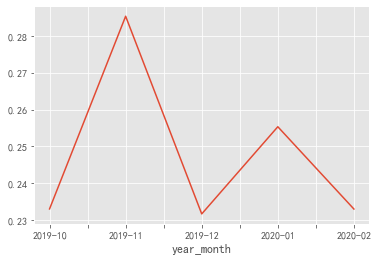

In [87]:
(user_month_counts_get.sum()/user_month_counts_get.count()).plot()

In [88]:
(user_month_counts_get.sum()/user_month_counts_get.count()).mean()

0.24770263667456885

### 7.2.3 人均每次购买量

In [89]:
#人均消费天数
user_consumption_days=data_alls_purchase.groupby('user_id')['date'].apply(get_month_unique).unstack()
average_consumption_days=user_consumption_days.iloc[:,0].sum()/all_customers
average_consumption_days

1.3967408024032284

In [90]:
#人均购买量（以天为单位）
all_count/all_customers/average_consumption_days

8.337427525669678

### 7.2.4 小结
店铺的运营活动成功引流，指标峰值明显；但客户的质量不高，有将近80%的客户为一次性购物后就流失，客户的忠诚度不高
价格不是导致客户流失的原因。
客户喜欢一次性购买多件产品，复购率达90%，但客户的回购率不高，仅为25%左右。

## 7.3 基于客户生命周期观察客户结构


    客户生命周期—新老活跃流失，逻辑关系：
    1.本月没有消费
    1）这个月是首月，则这个月是未注册
    2）上个月是未注册，则这个月是未注册
    3）上个月是消费，则这个月是不活跃
    4）上个月是不活跃，则这个月是不活跃
    2.本月有消费
    1）上个月是未注册，则这个月是新客户
    2）上个月是消费，则这个月是活跃
    3）上个月是不活跃，则这个月是回流

In [91]:
#先以透视表查看客户在每个月的表现状态
user_active_counts = data_alls_purchase.pivot_table(index = 'user_id',
                               columns = 'year_month',
                               values = 'price',
                               aggfunc = 'count').fillna(0)
user_active_counts

year_month,2019-10,2019-11,2019-12,2020-01,2020-02
user_id,,,,,
9794320,0.0,4.0,0.0,0.0,0.0
10079204,0.0,2.0,0.0,0.0,0.0
10280338,0.0,16.0,0.0,1.0,69.0
12055855,0.0,0.0,4.0,0.0,0.0
12936739,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...
622065819,0.0,0.0,0.0,0.0,4.0
622066161,0.0,0.0,0.0,0.0,4.0
622067983,0.0,0.0,0.0,0.0,10.0


In [92]:
#再把每个月消费与不消费变成1与0，我们只需要知道该月消费是否
user_active_counts_new = user_active_counts.applymap(lambda x:1 if x>0 else 0)
user_active_counts_new

year_month,2019-10,2019-11,2019-12,2020-01,2020-02
user_id,,,,,
9794320,0,1,0,0,0
10079204,0,1,0,0,0
10280338,0,1,0,1,1
12055855,0,0,1,0,0
12936739,0,0,0,1,0
...,...,...,...,...,...
622065819,0,0,0,0,1
622066161,0,0,0,0,1
622067983,0,0,0,0,1


In [93]:
#根据上面的逻辑写出代码
def get_user_status(data):
    status=[]
#根据月个数写出循环次数
    for i in range(5):
        #对本月进行消费判断
        #1.本月没有消费
        if data[i]==0:
            #不是首月
            if len(status)>0:
                if status[i-1]=='unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            #是首月
            else:
                status.append('unreg')
        #2.本月有消费
        else:
            #不是首月
            if len(status)>0:
                if status[i-1]=='unreg':
                    status.append('new')
                elif status[i-1]=='new':
                    status.append('active')
                else:
                    status.append('return')
            #是首月
            else:
                status.append('new')
    data.iloc[0:]=status
    return data

In [94]:
#将客户结构函数应用到数据中
user_purchase_stats =user_active_counts_new.apply(get_user_status,axis = 1)
#user_purchase_stats = user_month_counts_pivoted.apply(lambda x:get_user_status(x),axis=1)
user_purchase_stats

year_month,2019-10,2019-11,2019-12,2020-01,2020-02
user_id,,,,,
9794320,unreg,new,unactive,unactive,unactive
10079204,unreg,new,unactive,unactive,unactive
10280338,unreg,new,unactive,return,return
12055855,unreg,unreg,new,unactive,unactive
12936739,unreg,unreg,unreg,new,unactive
...,...,...,...,...,...
622065819,unreg,unreg,unreg,unreg,new
622066161,unreg,unreg,unreg,unreg,new
622067983,unreg,unreg,unreg,unreg,new


In [95]:
#将未注册的客户调整为缺失值，便于对其他类型进行计数
purchase_stats_ct = user_purchase_stats.replace('unreg',np.NaN).apply(lambda x:pd.value_counts(x))
purchase_stats_ct

year_month,2019-10,2019-11,2019-12,2020-01,2020-02
active,NaN,4763.0,2618,1678,1810
new,25762.0,26761.0,19702,20427,17866
return,NaN,NaN,3293,6115,6083
unactive,NaN,20999.0,46612,64432,84759


Text(0, 0.5, '客户人数')

<Figure size 1440x864 with 0 Axes>

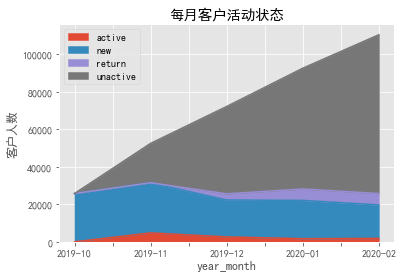

In [96]:
plt.figure(figsize=(20,12))
purchase_stats_ct.fillna(0).T.plot.area()    #制作面积图，可以更直观的观察走势
plt.title('每月客户活动状态')
plt.ylabel('客户人数')

In [97]:
#查看每个月各类客户的占比
purchase_status_ct_rate = purchase_stats_ct.fillna(0).T.apply(lambda x:x/x.sum(),axis = 1)
purchase_status_ct_rate

,active,new,return,unactive
year_month,,,,
2019-10,0.000000,1.000000,0.000000,0.000000
2019-11,0.090684,0.509510,0.000000,0.399806
2019-12,0.036248,0.272786,0.045594,0.645372
2020-01,0.018111,0.220470,0.066000,0.695419
2020-02,0.016377,0.161657,0.055041,0.766925


从观看客户生命周期状态图可以知道活跃客户越来越少，流失客户越来越多

## 7.4 基于RFM模型的客户分群

In [98]:
#获取R/F/M
rfm = data_alls_purchase.pivot_table(index = 'user_id',
                    values = {'event_time','price','user_session'},
                    aggfunc = {'event_time':'max',
                               'price':'sum',
                               'user_session':'count'})
rfm.head()

,event_time,price,user_session
user_id,,,
9794320,2019-11-25 05:07:13,12.68,4
10079204,2019-11-06 10:43:30,25.81,2
10280338,2020-02-19 15:21:31,177.83,86
12055855,2019-12-20 12:05:29,16.54,4
12936739,2020-01-17 07:51:19,29.89,2


In [99]:
#选择固定节点时间“2020-3-1”
rfm['R'] = (pd.to_datetime('2020-3-1')-pd.to_datetime(rfm.event_time)).dt.days

In [100]:
rfm.rename(columns = {'user_session':'F','price':'M'},inplace = True)

In [101]:
rfm.head()

,event_time,M,F,R
user_id,,,,
9794320,2019-11-25 05:07:13,12.68,4,96
10079204,2019-11-06 10:43:30,25.81,2,115
10280338,2020-02-19 15:21:31,177.83,86,10
12055855,2019-12-20 12:05:29,16.54,4,71
12936739,2020-01-17 07:51:19,29.89,2,43


用户分层打分确认分层的维度表如下： 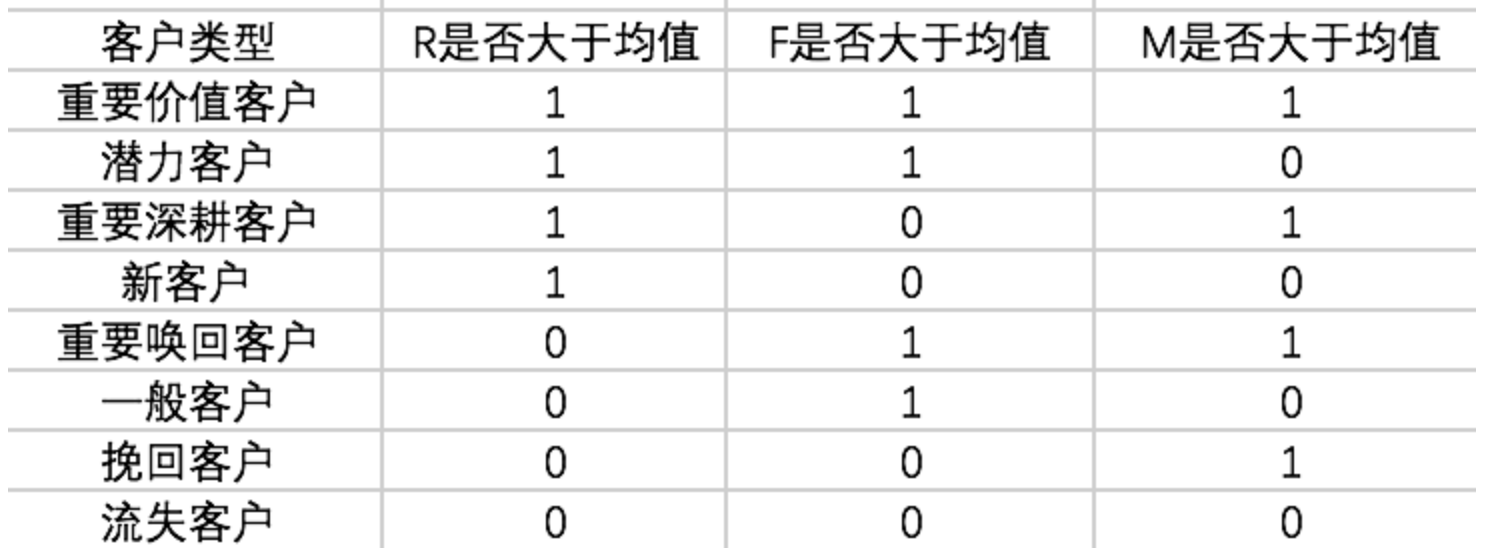

In [102]:
#给每条数据新增标签
def rfm_label(x):
    level = x.apply(lambda x:'1' if x>= 0 else '0')
    #这里的level数据都是字符串，可以直接合并
    label = level.R + level.F + level.M
    Standard = {
        '111':'重要价值客户',
        '110':'消费潜力客户',
        '101':'频次深耕客户',
        '100':'新客户',
        '011':'重要价值流失预警客户',
        '010':'一般客户',
        '001':'高消费唤回客户',
        '000':'流失客户'
    }
    #result =label.map(Standard)
    result = Standard.get(label)
    return result

In [103]:
#以均值作为RFM各值分层标准，大于均值为1，小于均值为0
rfm['label'] = rfm[['R','F','M']].apply(lambda x:x-x.mean()).apply(rfm_label,axis = 1)

In [104]:
rfm.head()

,event_time,M,F,R,label
user_id,,,,,
9794320,2019-11-25 05:07:13,12.68,4,96,新客户
10079204,2019-11-06 10:43:30,25.81,2,115,新客户
10280338,2020-02-19 15:21:31,177.83,86,10,重要价值流失预警客户
12055855,2019-12-20 12:05:29,16.54,4,71,新客户
12936739,2020-01-17 07:51:19,29.89,2,43,流失客户


In [105]:
#查看各层客户的RFM详细情况
rfm.groupby('label').sum()

,M,F,R
label,,,
一般客户,187978.89,73548,140137
新客户,897956.36,170826,4149395
流失客户,776229.63,147893,1073610
消费潜力客户,214702.75,87051,573181
重要价值客户,1036507.77,227622,821016
重要价值流失预警客户,2471261.97,529764,369538
频次深耕客户,383392.63,24993,447826
高消费唤回客户,383800.29,25310,131007


In [106]:
#查看各层客户的人数占比情况
rfm_precent = (rfm.groupby('label').R.count()/rfm.groupby('label').R.count().sum()*100).sort_values(ascending=False)
rfm_precent

label
新客户           34.567220
流失客户          29.498362
重要价值流失预警客户    12.412458
重要价值客户         7.138204
消费潜力客户         4.793789
一般客户           4.096165
频次深耕客户         3.764998
高消费唤回客户        3.728804
Name: R, dtype: float64

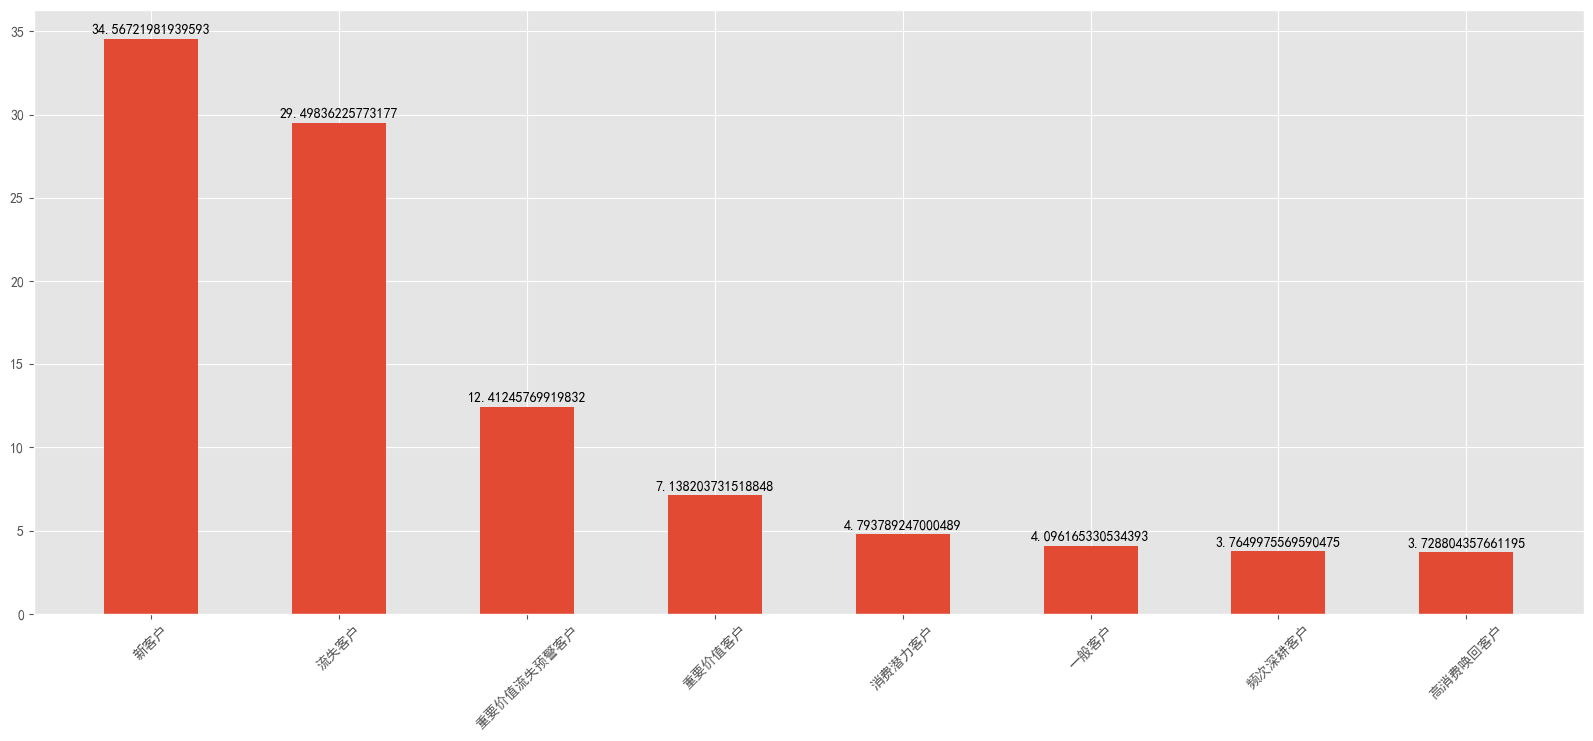

In [107]:
plt.figure(figsize=(20,8),dpi=100)
rects = plt.bar(rfm_precent.index,rfm_precent.values,width=0.5)
plt.xticks(range(len(rfm_precent.index)),rfm_precent.index,rotation=45)

for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 0.3,str(height), ha='center')
plt.show()

通过RFM模型分析可以看出，大多数客户都是价值度不高的客户，高价值用户很少，客户消费结构并不乐观，其中新客户最多，同时流失人数位居第二，说明店铺的运营活动（如限时折扣）成功带来了新客户，但客户一次购买后就流失，并没有进行回购，说明店铺的运营活动并不能带来长期收益，产品接下来的工作重点应该是针对流失客户的需求设计。

## 7.5 消费产品维度分析

## 7.5.1 消费产品总体情况

In [108]:
#求出不同产品的消费总金额和购买总次数
test_category=data_alls_purchase.groupby('category_id').price.agg(['sum','count'])
#再求出产品的单价
test_category['amount']=test_category['sum']/test_category['count']
#求出产品月均销售量
test_category['average_count']=test_category['count']/5
test_category.rename(columns={'sum':'消费总金额','count':'购买总次数','amount':'产品单价','average_count':'产品月均销售量'},inplace=True)
#查看消费产品的详细情况
test_category.describe()

,消费总金额,购买总次数,产品单价,产品月均销售量
count,468.000000,468.000000,468.000000,468.000000
mean,13572.286944,2750.014957,8.642558,550.002991
std,35937.849183,6943.011359,16.067662,1388.602272
min,3.270000,1.000000,0.377921,0.200000
25%,682.485000,136.750000,3.239340,27.350000
50%,2749.910000,604.500000,5.292396,120.900000
75%,10076.055000,2333.750000,8.485069,466.750000
max,418363.330000,80137.000000,201.323333,16027.400000


## 7.5.2 最喜爱产品的特征

In [109]:
#查看客户最喜爱消费前十的产品
test_category.sort_values(by='购买总次数',ascending=False)[:10]

,消费总金额,购买总次数,产品单价,产品月均销售量
category_id,,,,
1487580007675986893,102743.07,80137,1.282093,16027.4
1487580006317032337,179969.53,50555,3.559876,10111.0
1487580005092295511,418363.33,44870,9.323899,8974.0
1487580005595612013,134047.48,44334,3.023582,8866.8
1487580005671109489,108903.93,43452,2.506304,8690.4
1602943681873052386,186388.51,36216,5.146579,7243.2
1487580009286598681,22963.82,33862,0.678159,6772.4
1487580005268456287,265312.54,30450,8.713056,6090.0
1487580005134238553,68459.20,25702,2.663575,5140.4


In [110]:
#查看客户最喜爱的前十产品的描述统计
test_category.sort_values(by='购买总次数',ascending=False)[:10].describe()

,消费总金额,购买总次数,产品单价,产品月均销售量
count,10.000000,10.000000,10.000000,10.000000
mean,152705.315000,41372.000000,3.854992,8274.400000
std,118579.684934,16183.272853,2.995486,3236.654571
min,22963.820000,24142.000000,0.678159,4828.400000
25%,77030.167500,31303.000000,1.866171,6260.600000
50%,121475.705000,39834.000000,2.843578,7966.800000
75%,184783.765000,44736.000000,4.749903,8947.200000
max,418363.330000,80137.000000,9.323899,16027.400000


可以看到客户五个月以来产品销售情况是：
最倾向的产品单价均值在3.85 dollar，低于产品总体单价均值，说明顾客更青睐便宜实惠的产品
而前十类最喜爱产品的月均销售量是8274，从（5.2）计算出月均销售总单数数是257376，月均每订单购买率是31%，即约每下31个单有一个单是前十的产品，月均购买总客户数是22103，月均每客户购买率37.0%，约四个半个月客户才会买一件销量前十的产品，说明热销产品并不热销。

### 7.5.3 人均购买产品类数

In [111]:
#人均购买产品种类数
average_category=data_alls_purchase.groupby('user_id')['category_id'].apply(get_month_unique).unstack()
(average_category.sum()/all_customers)[0]

5.824408693606471

In [112]:
#人均每次购买产品种类数
(average_category.sum()/all_customers)[0]/average_consumption_days

4.169999676092378

### 7.5.4 小结
从产品维度看：
客户更喜欢低价产品；
热销产品并不热销；
客户每次购买多类产品。

# 八、结论

    通过电商平台这五个月的整体流量、转化率等方面分析电商的运营状况可以得到以下结论：
    
1.日浏览量与日客户消费金额趋势最为接近，说明浏览量与销售额有着强相关关系，浏览量指标需要引起重视，例如十一月的黑五促销活动只带来了比平时多11.049%的流量，而圣诞节期间快递停运造成的物流时效变长导致了比平时少15.362%的流量，说明促销活动的力度还有加大的空间。

2.新客户的运营策略有待提升。数据显示，新客户的购买成交率低，仅一次购买便流失的居多，说明需要将重点放在如何将新客户转变为留存客户的问题上进行运营，将新用户的转化率和回购率等指标作为重点kpi。新用户在加购这一步的运营已经有了显著效果，但是在促进购买这一步需要重点运营。

3.存量客户最具商业价值。本次报告研究期中，黑五活动期间无论是浏览量、客户数量、加购量、购买量还是加购和购买转化率，每一个指标都处于研究期中的高位水平，说明在存量客户的基础上进行促销活动是能够最大化销量的策略。
    
    通过购买时间、购买产品这两大个维度上的消费金额、消费次数、复购率、回购率等指标来分析客户消费行为去了解客户消费习惯以及消费现状，可以得到以下结论：

1.总体上，该平台客户结构不稳定，销售额受新增客户的影响大。
    在5个月内，从客户生命周期可以看到客户活跃越来越低，流失越来越多，且新客户越来越少，约80%客户当天流入当天流失，平台每天销售额受到新增客户数量波动比较大。

2.店铺运营活动即时有效，但留不住新客户，也即留存率低。
    客户购买受到活动运营活动影响比较大，购买总金额、总人数、总次数峰值都靠近这些活动时间附近，许多客户的首购都发生在这些时间段上，引流是有效果的，但一天购物就流失的客户达到总体客户80%，留不住新客户。

3.所有客户都喜欢一次性购买产品且买多种多样的产品，做好组合销售策略是增长销售额的一个好方法。
    复购率月均90%，人均每次购买量8件，人均每次购买种类4种，说明客户在购买商品时是比较果断的，习惯要么不买要么买多点，做好组合销售策略是增长销售额的一个方法。

4.价格没问题可能产品品质不够是客户流失的原因。
    当天流入当天流失的新客户的总体消费能力比能二次购买的客户的强，客户最喜爱的产品均单价是3.85dollar，价格不高，但客户每四个半月才会购买一件，价格低但还是不够有吸引力，商家以低价引流的策略并不能奏效。

    建议：改善用户结构，提高新用户的留存率，增强用户结构的稳定性。在使用新用户引流策略时注意提高新用户的加购至购买步的转化率，使得最终的收益落到实处。从产品品质、竞品差异、客服态度、物流速度等方面做用户体验调研来完善销售运营策略。具体运营策略建议如下：
    
    1.在新用户的留存上，一方面，可以采取一些精准营销的手段来提高留存率：构建合理的用户画像体系以及推荐系统，匹配合适的商品给新用户。另一方面，可以通过用户触达策略提高用户对电商平台以及商品的记忆度，例如邮件、短信等外部触达和通知消息、积分信息等内部触达，加强新用户对商品的记忆。

    2.在新用户加购至购买步的促进上，可以在加购后的短时间内对客户进行邮件、短信提醒，唤起客户对购物车中的商品记忆。同时也可以在内部开展一些价格测试，归纳价格敏感性高的用户特征，对符合这些特征的新用户进行一些优惠券补贴，从而提高购买转化。

    3.在存量客户运营上，可以通过完善积分和会员体系来提高存量客户的用户粘性。相当一部分存量客户都具有很高的商业价值，对于这部分客户应该有合理的会员管理体系和积分体系。会员制度应该做到精细化运营，可以根据会员等级来划分，如无差别会员、等级会员、付费会员等。积分制度则主要可以采取积分兑换、积分抵扣等方式来实现。
    
    4.在提高用户购买频率和购买件数上，可以通过组合销售，会员日活动，引导客户订阅并定期推送活动和商品，设置老客户回流红包等手段，刺激客户的购买需求，提升购买频率和购面件数。当然同时要注意提升产品质量，服务质量，从而提升用户的购物体验